## Importing libraries

In [473]:
import numpy as np
import pandas as pd
import yfinance as yf
import requests
import bs4 as bs
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

##Setting lines and rows printing configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Getting the stock tickers for all the companies in the S&P500

In [474]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
SP_500_tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    SP_500_tickers.append(ticker)

In [191]:
SP_500_tickers = [s.replace('\n', '') for s in SP_500_tickers]
SP_500_tickers

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'CHRW',
 'CDNS',
 'CZR',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CDAY',
 'CERN',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMC

**Number of companies listed (inlcluding some delisted ones in the S&P500 Index)**

In [192]:
len(SP_500_tickers)

505

## Getting historical data for the companies in a defined period of time

**Defining period of time for the analysis**

In [193]:
start_time = dt.datetime(2020,1,1)
end_time = dt.datetime(2020,12,31)

**Downloading data**

In [194]:
data = yf.download(SP_500_tickers, start = start_time, end = end_time)

[*********************100%***********************]  505 of 505 completed

3 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- OGN: Data doesn't exist for startDate = 1577833200, endDate = 1609369200
- BF.B: None


**Checking for the shape (number of companies & date records) & features of the data**

In [195]:
data.shape

(253, 3030)

**Number of date records -- 253 days are registred (only business days)**

In [174]:
data.index

DatetimeIndex(['2019-12-31', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Date', length=253, freq=None)

**Original features of the data (originally, we have 6 dimensions for each stock)**

In [175]:
list(data.columns.levels[0])

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

**Dropping stocks with missing data**

In [198]:
data.dropna(inplace = True, axis = 1)

In [199]:
data.shape

(253, 3000)

**Getting stocks with all features filled**

In [216]:
valid_stocks = []
number_original_features = len(data.columns.levels[0])
lists_stocks_per_feature = []

for feature in data.columns.levels[0]:
    lists_stocks_per_feature.append(data[feature].columns)

## Getting the intersection of the lists of available stocks per feature
valid_stocks = list(set.intersection(*[set(x) for x in lists_stocks_per_feature]))

In [218]:
len(valid_stocks)

500

**Generating a new feature - DAILY RETURN**

In [242]:
def return_daily_return_as_new_feature(data, valid_stocks):
    for stock in list(valid_stocks):
        data[("Daily Return", stock)] = data[("Adj Close",stock)].pct_change()

In [243]:
return_daily_return_as_new_feature(data, valid_stocks)

**Daily return is a new feature of the data - we have now 7 dimensions**

In [244]:
list(data.columns.levels[0])

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Daily Return']

In [245]:
list(data["Daily Return"].columns) == valid_stocks

True

**Let's now generate the dimensions that we will use with the PCA reduction method: monthly mean volatility, monthly mean return, monthly mean drawdown, monthly mean traded volume**

<span style="color:red">**Generating a dataframe with monthly returns for all stocks**</span>

In [246]:
def return_monthly_accrued_return_for_each_stock(data, valid_stocks):
    
    monthly_returns = pd.DataFrame(data = [], index = range(1,13), columns = valid_stocks)
    daily_returns = data["Daily Return"].iloc[1: , :]
    
    for stock in valid_stocks:
        for month in range(1,13):
            current_stock_monthly_return = 1.0
            current_data = daily_returns[stock][daily_returns.index.month == month]
            number_of_rows = len(current_data)
            for i in range(0, number_of_rows):
                current_stock_monthly_return = current_stock_monthly_return*(1 + current_data.iloc[i])    
            monthly_returns.loc[month][stock] = (current_stock_monthly_return - 1)
            
    return monthly_returns   

In [247]:
monthly_returns = return_monthly_accrued_return_for_each_stock(data, valid_stocks)

<span style="color:red">**Expected to have a dataframe with 12 rows**</span>

In [248]:
monthly_returns.shape

(12, 500)

**Generating Monthly Mean Return for each stock**

In [249]:
monthly_mean_returns = np.mean(monthly_returns)

Text(0.5, 1.0, 'S&P500 - Mean Monthly Return')

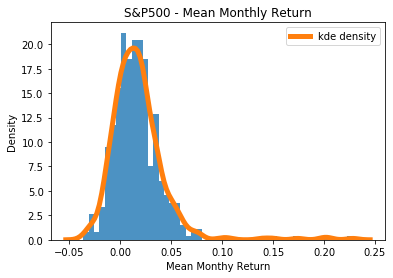

In [268]:
plt.hist(monthly_mean_returns, bins = 50, density = True, alpha = 0.8)
sns.kdeplot(monthly_mean_returns, label = "kde density", linewidth = 5)
plt.xlabel("Mean Monthy Return")
plt.ylabel("Density")
plt.title("S&P500 - Mean Monthly Return")

<span style="color:blue">**Generating a dataframe with monthly traded volume for all stocks**</span>

In [251]:
def return_monthly_total_traded_volume_for_each_stock(data, valid_stocks):
    
    daily_volumes = data["Volume"].dropna(axis = 1)
    monthly_traded_volumes = pd.DataFrame(data = [], index = range(1,13), columns = valid_stocks)
    
    for stock in valid_stocks:
        for month in range(1,13):
            current_stock_monthly_traded_volume = 0.0
            current_data = daily_volumes[stock][daily_volumes.index.month == month]
            number_of_rows = len(current_data)
            for i in range(0, number_of_rows):
                current_stock_monthly_traded_volume = current_stock_monthly_traded_volume + current_data.iloc[i]    
            monthly_traded_volumes.loc[month][stock] = current_stock_monthly_traded_volume
            
    return monthly_traded_volumes  

In [252]:
monthly_traded_volumes = return_monthly_total_traded_volume_for_each_stock(data, valid_stocks)

<span style="color:red">**Expected to have a dataframe with 12 rows**</span>

In [253]:
monthly_traded_volumes.shape

(12, 500)

**Generating Monthly Mean Traded Volume for each stock**

In [254]:
monthly_mean_traded_volumes = np.mean(monthly_traded_volumes)

Text(0.5, 1.0, 'S&P500 - Mean Monthly Traded Volume')

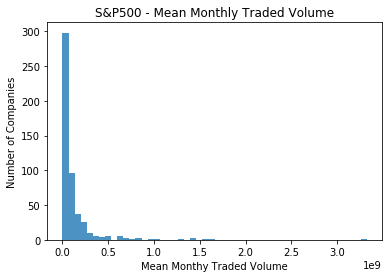

In [271]:
plt.hist(monthly_mean_traded_volumes, bins = 50, alpha = 0.8)
plt.xlabel("Mean Monthy Traded Volume")
plt.ylabel("Number of Companies")
plt.title("S&P500 - Mean Monthly Traded Volume")

<span style="color:blue">**Generating a dataframe with monthly volatility for each stock**</span>

In [260]:
def return_monthly_volatility_for_each_stock(data, valid_stocks):
    
    daily_returns = data["Daily Return"].iloc[1: , :]
    monthly_volatiities = pd.DataFrame(data = [], index = range(1,13), columns = valid_stocks)
    
    for stock in valid_stocks:
        for month in range(1,13):
            current_data = daily_returns[stock][daily_returns.index.month == month]   
            monthly_volatiities.loc[month][stock] = current_data.std()
            
    return monthly_volatiities

In [261]:
monthly_volatiities = return_monthly_volatility_for_each_stock(data, valid_stocks)

<span style="color:red">**Expected to have a dataframe with 12 rows**</span>

In [263]:
monthly_volatiities.shape

(12, 500)

**Generating Monthly Mean Volatility for each stock**

In [262]:
monthly_mean_volatility = np.mean(monthly_volatiities)

Text(0.5, 1.0, 'S&P500 - Mean Monthly Volatility')

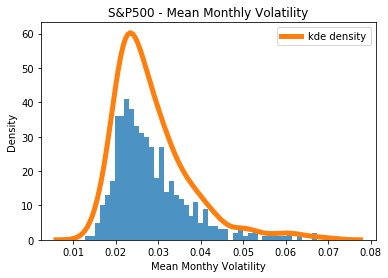

In [283]:
plt.hist(monthly_mean_volatility, bins = 50, alpha = 0.8)
sns.kdeplot(monthly_mean_volatility, label = "kde density", linewidth = 5)
plt.xlabel("Mean Monthy Volatility")
plt.ylabel("Density")
plt.title("S&P500 - Mean Monthly Volatility")

<span style="color:blue">**Generating a dataframe with maximum monthly drawdown for each stock**</span>

In [277]:
def return_monthly_maximum_drawdown_for_each_stock(data, valid_stocks):
    
    adjusted_close_prices = data["Adj Close"]
    monthly_drawdowns = pd.DataFrame(data = [], index = range(1,13), columns = valid_stocks)
    
    for stock in valid_stocks:
        for month in range(1,13):
            current_data = adjusted_close_prices[stock][adjusted_close_prices.index.month == month]
            current_data_max = current_data.max()
            current_data_min = current_data.min()
            monthly_drawdowns.loc[month][stock] = current_data_max - current_data_min
            
    return monthly_drawdowns

In [278]:
monthly_drawdowns = return_monthly_maximum_drawdown_for_each_stock(data, valid_stocks)

<span style="color:red">**Expected to have a dataframe with 12 rows**</span>

In [279]:
monthly_drawdowns.shape

(12, 500)

**Generating Monthly Mean Maximum Drawdown for each stock**

In [281]:
monthly_mean_drawdown = np.mean(monthly_drawdowns)

Text(0.5, 1.0, 'S&P500 - Mean Monthly Maximum Drawdown')

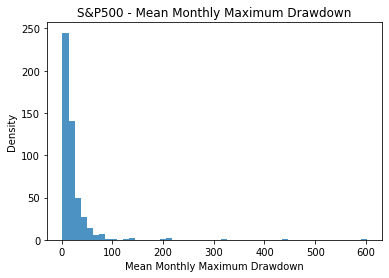

In [288]:
plt.hist(monthly_mean_drawdown, bins = 50, alpha = 0.8)
plt.xlabel("Mean Monthly Maximum Drawdown")
plt.ylabel("Density")
plt.title("S&P500 - Mean Monthly Maximum Drawdown")

**Generating a DataFrame with the final features**

In [475]:
final_features = pd.DataFrame({ 'Mean Monthly Return': monthly_mean_returns, 'Mean Monthly Traded Volume': monthly_mean_traded_volumes, 'Mean Monthly Volatility': monthly_mean_volatility, 'Mean Monthly Maximum Drawdown': monthly_mean_drawdown})


In [476]:
final_features.shape

(500, 4)

In [477]:
final_features.head()

,Mean Monthly Return,Mean Monthly Traded Volume,Mean Monthly Volatility,Mean Monthly Maximum Drawdown
BXP,-0.018021,2.889944e+07,0.031926,20.626967
LYB,0.012858,5.312328e+07,0.038147,14.157981
CDW,-0.002439,2.164714e+07,0.027089,16.625102
KLAC,0.038140,2.834659e+07,0.032778,36.332344
AFL,-0.006073,8.517120e+07,0.028375,6.754586


## Standardizing Data for PCA Algorithm - Can we identify industry sector with these features ?

In [478]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
final_features = pd.DataFrame(scaler.fit_transform(final_features), columns = final_features.columns, index = final_features.index)

In [479]:
final_features.head()

,Mean Monthly Return,Mean Monthly Traded Volume,Mean Monthly Volatility,Mean Monthly Maximum Drawdown
BXP,-1.278639,-0.377589,0.381370,-0.053132
LYB,-0.161947,-0.278128,1.064556,-0.207503
CDW,-0.715125,-0.407366,-0.149932,-0.148629
KLAC,0.752324,-0.379859,0.474904,0.321647
AFL,-0.846567,-0.146544,-0.008708,-0.384171


**Getting companies industry sector for classification analyses of PCA's performance**

<span style="color:red">**Attention! This cell takes about half hour to execute.**</span>

In [322]:
valid_stock_sectors = []
i = 0 
for stock in valid_stocks:
    tickerdata = yf.Ticker(stock) 
    valid_stock_sectors.append(tickerdata.info['sector'])
    i = i + 1
    print(f'Industry sectors found: {i}\n')

Industry sectors found: 1

Industry sectors found: 2

Industry sectors found: 3

Industry sectors found: 4

Industry sectors found: 5

Industry sectors found: 6

Industry sectors found: 7

Industry sectors found: 8

Industry sectors found: 9

Industry sectors found: 10

Industry sectors found: 11

Industry sectors found: 12

Industry sectors found: 13

Industry sectors found: 14

Industry sectors found: 15

Industry sectors found: 16

Industry sectors found: 17

Industry sectors found: 18

Industry sectors found: 19

Industry sectors found: 20

Industry sectors found: 21

Industry sectors found: 22

Industry sectors found: 23

Industry sectors found: 24

Industry sectors found: 25

Industry sectors found: 26

Industry sectors found: 27

Industry sectors found: 28

Industry sectors found: 29

Industry sectors found: 30

Industry sectors found: 31

Industry sectors found: 32

Industry sectors found: 33

Industry sectors found: 34

Industry sectors found: 35

Industry sectors found: 36

I

Industry sectors found: 288

Industry sectors found: 289

Industry sectors found: 290

Industry sectors found: 291

Industry sectors found: 292

Industry sectors found: 293

Industry sectors found: 294

Industry sectors found: 295

Industry sectors found: 296

Industry sectors found: 297

Industry sectors found: 298

Industry sectors found: 299

Industry sectors found: 300

Industry sectors found: 301

Industry sectors found: 302

Industry sectors found: 303

Industry sectors found: 304

Industry sectors found: 305

Industry sectors found: 306

Industry sectors found: 307

Industry sectors found: 308

Industry sectors found: 309

Industry sectors found: 310

Industry sectors found: 311

Industry sectors found: 312

Industry sectors found: 313

Industry sectors found: 314

Industry sectors found: 315

Industry sectors found: 316

Industry sectors found: 317

Industry sectors found: 318

Industry sectors found: 319

Industry sectors found: 320

Industry sectors found: 321

Industry secto

<span style="color:blue">**Sector Analyses before PCA results**</span>

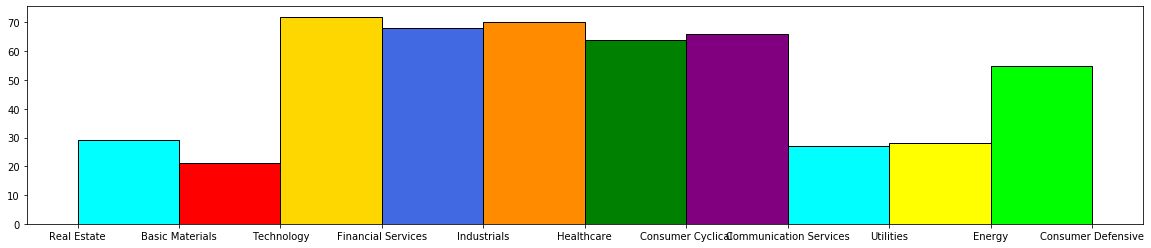

In [369]:
colors = ['aqua', 'red', 'gold', 'royalblue', 'darkorange', 'green', 'purple', 'cyan', 'yellow', 'lime', 'sienna']

fig, ax = plt.subplots(figsize=(20,4), facecolor='w')
cnts, values, bars = ax.hist(valid_stock_sectors, edgecolor='k')

for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(colors[i % len(colors)])

**Assigning a color to each sector**

In [397]:
available_sectors = list(set(valid_stock_sectors))
valid_stock_sectors_colors = []

for stock_sector in valid_stock_sectors:
    valid_stock_sectors_colors.append(colors[available_sectors.index(stock_sector)])

## Running PCA Algorithm

In [480]:
from sklearn.decomposition import PCA

In [489]:
pca_model_I = PCA(n_components = 4)

In [490]:
pca_results_I = pca_model_I.fit_transform(final_features)

Text(0.5, 1.0, 'PCA Results - Scattering')

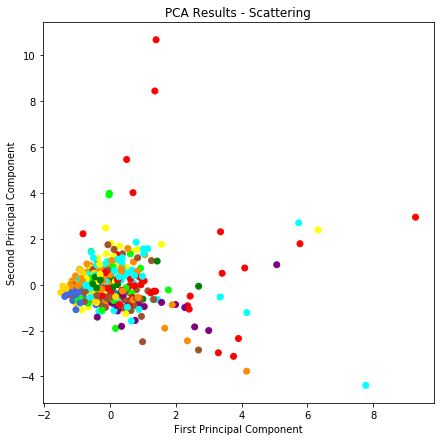

In [491]:
fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
plt.scatter(pca_results_I[:,0], pca_results_I[:,1], c = valid_stock_sectors_colors)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Results - Scattering")

In [492]:
print(available_sectors)  
print("\n")
print(colors)

['Technology', 'Consumer Cyclical', 'Consumer Defensive', 'Utilities', 'Industrials', 'Basic Materials', 'Energy', 'Real Estate', 'Healthcare', 'Communication Services', 'Financial Services']


['aqua', 'red', 'gold', 'royalblue', 'darkorange', 'green', 'purple', 'cyan', 'yellow', 'lime', 'sienna']


**What is the explained variance ratio by the principal components ?**

In [493]:
pca_model_I.explained_variance_ratio_

array([0.34522464, 0.29071279, 0.1934447 , 0.17061787])

## Can we enhance the industry sector clustering with more features (information) ?

**Getting annual dividends for each valid stock**

In [403]:
valid_stock_dividends = []
i = 0 
for stock in valid_stocks:
    tickerdata = yf.Ticker(stock) 
    valid_stock_dividends.append(tickerdata.info['dividendRate'])
    i = i + 1
    print(f'Ticker Annual Dividends Rate found: {i}\n')

Ticker Annual Dividends Rate found: 1

Ticker Annual Dividends Rate found: 2

Ticker Annual Dividends Rate found: 3

Ticker Annual Dividends Rate found: 4

Ticker Annual Dividends Rate found: 5

Ticker Annual Dividends Rate found: 6

Ticker Annual Dividends Rate found: 7

Ticker Annual Dividends Rate found: 8

Ticker Annual Dividends Rate found: 9

Ticker Annual Dividends Rate found: 10

Ticker Annual Dividends Rate found: 11

Ticker Annual Dividends Rate found: 12

Ticker Annual Dividends Rate found: 13

Ticker Annual Dividends Rate found: 14

Ticker Annual Dividends Rate found: 15

Ticker Annual Dividends Rate found: 16

Ticker Annual Dividends Rate found: 17

Ticker Annual Dividends Rate found: 18

Ticker Annual Dividends Rate found: 19

Ticker Annual Dividends Rate found: 20

Ticker Annual Dividends Rate found: 21

Ticker Annual Dividends Rate found: 22

Ticker Annual Dividends Rate found: 23

Ticker Annual Dividends Rate found: 24

Ticker Annual Dividends Rate found: 25

Ticker An

Ticker Annual Dividends Rate found: 204

Ticker Annual Dividends Rate found: 205

Ticker Annual Dividends Rate found: 206

Ticker Annual Dividends Rate found: 207

Ticker Annual Dividends Rate found: 208

Ticker Annual Dividends Rate found: 209

Ticker Annual Dividends Rate found: 210

Ticker Annual Dividends Rate found: 211

Ticker Annual Dividends Rate found: 212

Ticker Annual Dividends Rate found: 213

Ticker Annual Dividends Rate found: 214

Ticker Annual Dividends Rate found: 215

Ticker Annual Dividends Rate found: 216

Ticker Annual Dividends Rate found: 217

Ticker Annual Dividends Rate found: 218

Ticker Annual Dividends Rate found: 219

Ticker Annual Dividends Rate found: 220

Ticker Annual Dividends Rate found: 221

Ticker Annual Dividends Rate found: 222

Ticker Annual Dividends Rate found: 223

Ticker Annual Dividends Rate found: 224

Ticker Annual Dividends Rate found: 225

Ticker Annual Dividends Rate found: 226

Ticker Annual Dividends Rate found: 227

Ticker Annual Di

Ticker Annual Dividends Rate found: 404

Ticker Annual Dividends Rate found: 405

Ticker Annual Dividends Rate found: 406

Ticker Annual Dividends Rate found: 407

Ticker Annual Dividends Rate found: 408

Ticker Annual Dividends Rate found: 409

Ticker Annual Dividends Rate found: 410

Ticker Annual Dividends Rate found: 411

Ticker Annual Dividends Rate found: 412

Ticker Annual Dividends Rate found: 413

Ticker Annual Dividends Rate found: 414

Ticker Annual Dividends Rate found: 415

Ticker Annual Dividends Rate found: 416

Ticker Annual Dividends Rate found: 417

Ticker Annual Dividends Rate found: 418

Ticker Annual Dividends Rate found: 419

Ticker Annual Dividends Rate found: 420

Ticker Annual Dividends Rate found: 421

Ticker Annual Dividends Rate found: 422

Ticker Annual Dividends Rate found: 423

Ticker Annual Dividends Rate found: 424

Ticker Annual Dividends Rate found: 425

Ticker Annual Dividends Rate found: 426

Ticker Annual Dividends Rate found: 427

Ticker Annual Di

In [406]:
for i in range(0, len(valid_stock_dividends)):
    if valid_stock_dividends[i] == None:
        valid_stock_dividends[i] = 0.0

**Standardazing the dividend rates**

In [494]:
valid_stock_dividends = valid_stock_dividends - np.mean(valid_stock_dividends)

In [495]:
valid_stock_dividends = valid_stock_dividends/np.std(valid_stock_dividends)

In [496]:
final_features['Dividends'] = valid_stock_dividends

In [497]:
final_features.head(5)

,Mean Monthly Return,Mean Monthly Traded Volume,Mean Monthly Volatility,Mean Monthly Maximum Drawdown,Dividends
BXP,-1.278639,-0.377589,0.381370,-0.053132,1.034735
LYB,-0.161947,-0.278128,1.064556,-0.207503,1.332423
CDW,-0.715125,-0.407366,-0.149932,-0.148629,0.082132
KLAC,0.752324,-0.379859,0.474904,0.321647,1.173656
AFL,-0.846567,-0.146544,-0.008708,-0.384171,-0.116327


**Running PCA with dividends feature. Is there an enhancement ?**

In [501]:
pca_model_II = PCA(n_components = 5)

In [502]:
pca_results_II = pca_model_II.fit_transform(final_features)

Text(0.5, 1.0, 'PCA Results - Scattering')

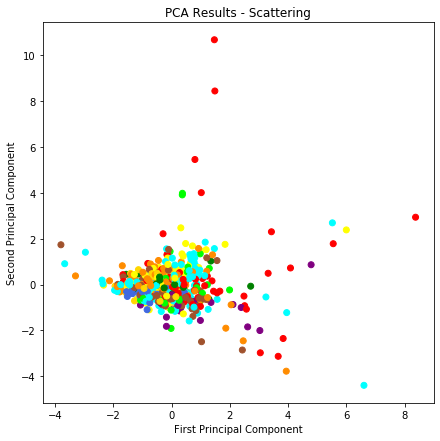

In [503]:
fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
plt.scatter(pca_results_II[:,0], pca_results_II[:,1], c = valid_stock_sectors_colors)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Results - Scattering")

In [505]:
pca_model_II.explained_variance_ratio_

array([0.31747913, 0.23257023, 0.16650597, 0.14749039, 0.13595428])

In [506]:
cumulative_sum_explained_variance = np.cumsum(pca_model_II.explained_variance_ratio_)

Text(0.5, 1.0, 'PCA Results with 5 features - Total Cumulative Explained Variance')

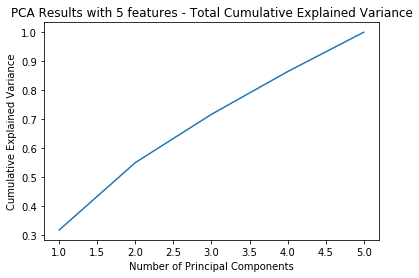

In [511]:
plt.plot(np.arange(1,6),cumulative_sum_explained_variance)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Results with 5 features - Total Cumulative Explained Variance")